### Spatial interpolation: Comparing Kriging with IDW

In this lab, we are using California Air Pollution data to illustrate IDW and Kriging interpolations in Python.

Kriging methods are implemented in the package `pykrige`. For IDW, you would need to implement it yourself.

The dataset contains 452 monitoring sites and each site is measuring several air quality indicators. 

In this particular example, we will be looking at ozone levels for California (averages for 1980-2009) using the variable **OZDLYAV** (unit is parts per billion) in the dataset.

Import libraries

In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np

You can upload the zip file to your current working directory, and you can use `!unzip CA_Counties` to unzip the file. You only need to unzip once.

In [2]:
!unzip -o CA_Counties #Add -o if you want to overwrite your files

Archive:  CA_Counties.zip
  inflating: __MACOSX/._CA_Counties  
  inflating: CA_Counties/CA_Counties_TIGER2016.shp  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.shp  
  inflating: CA_Counties/CA_Counties_TIGER2016.cpg  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.cpg  
  inflating: CA_Counties/CA_Counties_TIGER2016.sbx  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.sbx  
  inflating: CA_Counties/CA_Counties_TIGER2016.shx  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.shx  
  inflating: CA_Counties/CA_Counties_TIGER2016.dbf  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.dbf  
  inflating: CA_Counties/CA_Counties_TIGER2016.prj  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.prj  
  inflating: CA_Counties/CA_Counties_TIGER2016.sbn  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.sbn  
  inflating: CA_Counties/CA_Counties_TIGER2016.shp.xml  
  inflating: __MACOSX/CA_Counties/._CA_Counties_TIGER2016.sh

Read in the data used in this lab.

**Cal_air.csv**: the air quality data at each monitor station.

**CA_Counties_TIGER2016.shp**: the polygon shapefile of California.

In [3]:
oz = pd.read_csv("Cal_air.csv")
CA = gpd.read_file("CA_Counties/CA_Counties_TIGER2016.shp")

Check the first rows of `oz`:

In [4]:
oz.head()

,Unnamed: 0,LOCATION,SITE_NAME,SHORT_NAME,LATITUDE,LONGITUDE,CH4MAX1H,CH4DLYAV,COMAX8N,COMXN8N,...,OZHMX8ST,SO2MAX1H,SO2MX24N,SO2MX24O,SO2DLYAV,SULFURMX,THCMAX1H,THCDLYAV,TRSMAX1H,DAYOFWK
0,1,2001,Citrus Heights-Sunrise Blvd,Citrus_Hghts,38.6988,-121.2711,1.921959,1.699093,1.435813,1.424615,...,9.893635,0.003246,0.000803,0.001077,0.000753,NaN,2.605642,2.113489,NaN,4.001256
1,2,2008,El Capitan Beach,El_Capitan_B,34.4622,-120.0258,NaN,NaN,NaN,NaN,...,9.466335,0.001017,0.000279,0.000363,0.000279,NaN,2.079051,1.831332,0.000641,4.002197
2,3,2011,Eureka-Fort Avenue,Eureka-FtAve,40.8019,-124.1630,NaN,NaN,NaN,NaN,...,10.396226,0.002083,0.000188,0.000306,0.000215,0.003173,2.372549,2.023318,NaN,3.990654
3,4,2012,Fresno-Cal State #2,Fresno-ClSt2,36.8136,-119.7402,NaN,NaN,1.798955,1.781762,...,10.201579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.997995
4,5,2013,Fresno-Drummond Street,Fresno-Drmnd,36.7055,-119.7413,NaN,NaN,1.045182,1.038413,...,10.249258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.001840


The value of interest here is the ozone column which is named as : "OZDLYAV". The raw value is very small, we need to scale it a little bit by multiplying 1000.

In [5]:
oz["ozone"] = oz["OZDLYAV"] * 1000

Next, lets use the lat and long in the DataFrame to create a GeoDataFrame.

In [6]:
gdf = gpd.GeoDataFrame(oz, crs="EPSG:4269",geometry=
                    gpd.points_from_xy(x=oz.LONGITUDE, y=oz.LATITUDE))


It is always important to (re)project your data to make the crs to be consistent across different data layers.

Convert the coordinate reference system to the crs of the `CA` data

In [7]:
gdf = gdf.to_crs(CA.crs)

A simple plot overlaying the california counties with the sites.

<AxesSubplot:>

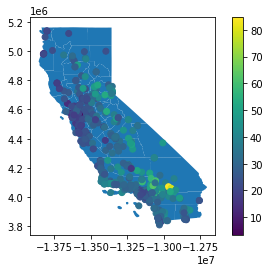

In [8]:
ax = CA.plot()
gdf.plot(ax=ax, column="ozone",legend=True)

Next, we will need to create a grid to cover CA, and will need to interpolate the value for each grid cell.

Here I get the bounding box for California:

In [9]:
xmin, ymin, xmax, ymax = CA.total_bounds
print(xmin, ymin, xmax, ymax)

-13857274.72986178 3832930.6170287207 -12705029.569540678 5162403.843161839


In this example, I am using a 10km resolution for each cell

In [10]:
grid_x = np.linspace(xmin, xmax, np.int((xmax-xmin)/10000))
grid_y = np.linspace(ymin, ymax, np.int((ymax-ymin)/10000))

Below are the codes performing the `OrdinaryKriging`. There are many parameters you can play with to get an optimal model. You can use `help()` to read the doc.

### Kriging

In [11]:
from pykrige.ok import OrdinaryKriging
help(OrdinaryKriging)

Help on class OrdinaryKriging in module pykrige.ok:

class OrdinaryKriging(builtins.object)
 |  OrdinaryKriging(x, y, z, variogram_model='linear', variogram_parameters=None, variogram_function=None, nlags=6, weight=False, anisotropy_scaling=1.0, anisotropy_angle=0.0, verbose=False, enable_plotting=False, enable_statistics=False, coordinates_type='euclidean', exact_values=True, pseudo_inv=False, pseudo_inv_type='pinv')
 |  
 |  Convenience class for easy access to 2D Ordinary Kriging.
 |  
 |  Parameters
 |  ----------
 |  x : array_like
 |      X-coordinates of data points.
 |  y : array_like
 |      Y-coordinates of data points.
 |  z : array-like
 |      Values at data points.
 |  variogram_model : str or GSTools CovModel, optional
 |      Specifies which variogram model to use; may be one of the following:
 |      linear, power, gaussian, spherical, exponential, hole-effect.
 |      Default is linear variogram model. To utilize a custom variogram model,
 |      specify 'custom'; you

Essentially, you need to pass:

- `x`: X-coordinates of monitor stations.
- `y`: Y-coordinates of monitor stations.
- `z`: Ozone values at monitor stations.
- `variogram_model`: Here you have the option to choose the variogram function. E.g. spherical, gaussian, linear, power, exponential, etc. In the code below, I used the spherical kernel.
- `variogram_parameters`: For more advanced modelling, you are able to set up the parameter for the variogram by explicitly define the sill, range and nugget. For example, you can follow this format to input your parameters for a gaussian function: `{'sill': s, 'range': r, 'nugget': n}`
- `nlags`: Number of averaging bins for the semivariogram. Default is 6.


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 74.66165755086173
Full Sill: 107.87394833847998
Range: 259461.75292240892
Nugget: 33.21229078761824 



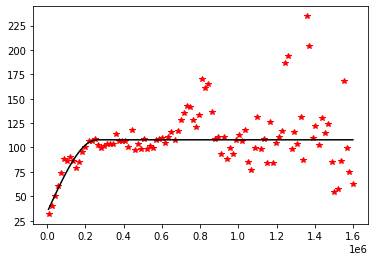

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [12]:
OK = OrdinaryKriging(x=gdf.geometry.x, 
                     y=gdf.geometry.y, 
                     z = gdf.ozone, 
                     variogram_model='spherical',
                     verbose=True, enable_plotting=True,nlags=100,
                    )

z1, ss1 = OK.execute('grid', grid_x, grid_y)

We find that the black curve (our variogram model) fits pretty well with the data. 

The above executaion returns you two objects: `z1` and `ss1` where `z1` is the interpolated values and `ss1` is the variance (uncertainty) of the interpolated values.

We are creating a new dataframe which is the grid we made earlier to hold the interpolated values. And we clip to the extent of CA.

In [13]:
#Here I'm using two standard deviation to show our uncertainty.

krig = np.hstack([z1.reshape(-1,1), 2*np.sqrt(ss1).reshape(-1,1)])

Create a meshed grid and a new GeoDataFrame to hold the interpolated values and uncertainty values.

In [14]:
xintrp, yintrp = np.meshgrid(grid_x, grid_y)

interpolated_krig = gpd.GeoDataFrame(krig, crs=CA.crs, geometry=
                    gpd.points_from_xy(x=xintrp.reshape(-1), y=yintrp.reshape(-1)))

Rename the columns and clip to the extent of California.

In [15]:
interpolated_krig.columns = ["krig_pred","krig_std","geometry"]

interpolated_krig = gpd.clip(interpolated_krig, CA)

Here are the codes for visualization.

Text(0.5, 1.0, 'Ozone map of California (Kriging)')

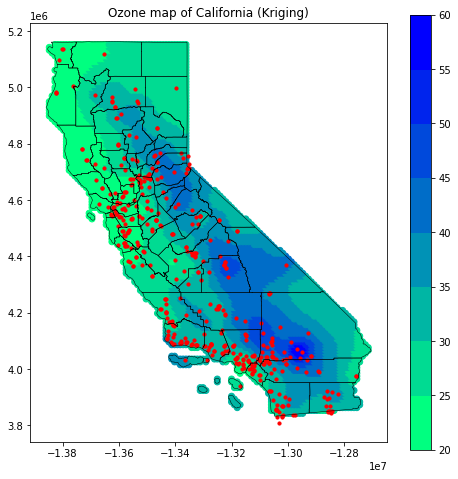

In [16]:
import matplotlib.pyplot as plt

#Using a winter colormap with 8 colors.
cmap = plt.get_cmap('winter_r',8)

#Specify the max and min of the colorbar to be 20 and 60.
ax = interpolated_krig.plot(column="krig_pred",figsize=(8, 8),
                            cmap=cmap,legend=True,vmin=20,vmax=60)

#Overlay the county boundaries
CA.boundary.plot(ax=ax,color="black",linewidths=0.5)

#Overlay the stations
gdf.plot(ax=ax, color="red", markersize=10,)

plt.title("Ozone map of California (Kriging)")

Do the same thing for the uncertainty.

Text(0.5, 1.0, 'Ozone map uncertainty')

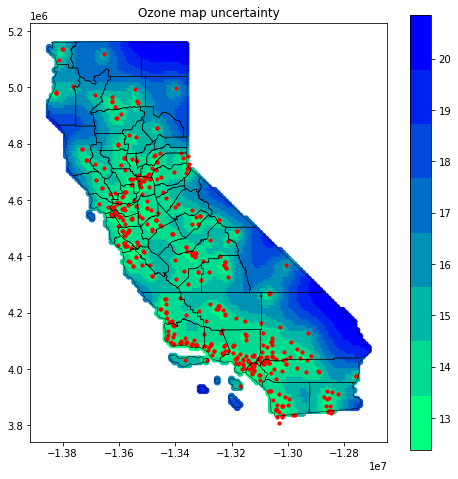

In [17]:
ax = interpolated_krig.plot(column="krig_std",figsize=(8, 8),cmap=cmap,legend=True)
CA.boundary.plot(ax=ax,color="black",linewidths=0.5)
gdf.plot(ax=ax, color="red", markersize=10,)
plt.title("Ozone map uncertainty")

We can see that our prediction is more certain for areas with stations, and gets more uncertain as away from the stations.

### IDW

Next we are gonna implement the IDW function ourselves. IDW is straight forward to implement. 

Basically for each gridcell, we need to 
- Calculate the distance *d* from the gridcell to each of the site
- Calculate the weight *w* based on the distance inversed (to the power of p)
- Calculate the interpolated value as the weighted average over the sum of the weights. *sum(z*w)/sum(w)*


In [18]:
%%time

z_star = []
p = 2
for y in grid_y:
    for x in grid_x:
        d = np.sqrt((gdf.geometry.x - x)**2 + (gdf.geometry.y - y)**2)
        z = gdf.ozone
        w = 1/(d**p)
        
        z_xy = np.sum(z*w)/np.sum(w)
        z_star.append(z_xy)


CPU times: user 25 s, sys: 196 ms, total: 25.2 s
Wall time: 25.6 s


In [19]:
interpolated_idw = gpd.GeoDataFrame(np.array(z_star).reshape(-1), crs=CA.crs, geometry=
                    gpd.points_from_xy(x=xintrp.reshape(-1), y=yintrp.reshape(-1)))

interpolated_idw.columns = ["idw","geometry"]
interpolated_idw = gpd.clip(interpolated_idw, CA)

Text(0.5, 1.0, 'Ozone map of California (IDW)')

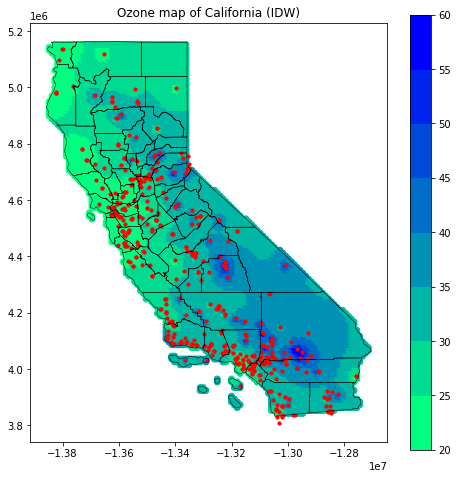

In [20]:
ax = interpolated_idw.plot(column="idw",figsize=(8, 8),cmap=cmap,legend=True,vmin=20,vmax=60)
CA.boundary.plot(ax=ax,color="black",linewidths=0.5)
gdf.plot(ax=ax, color="red", markersize=10,)

plt.title("Ozone map of California (IDW)")

Compare both methods side-by-side. Which one do you think is better?

Text(0.5, 1.0, 'Ozone map of California (IDW)')

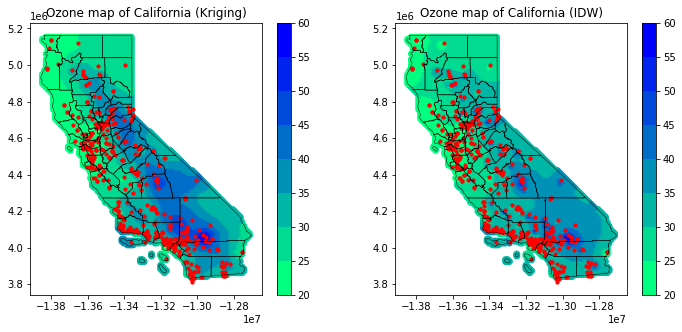

In [21]:
fig, axes = plt.subplots(1, 2,figsize=(12,5))

interpolated_krig.plot(ax = axes[0],column="krig_pred",cmap=cmap,legend=True,vmin=20,vmax=60)
CA.boundary.plot(ax = axes[0],color="black",linewidths=0.5)
gdf.plot(ax = axes[0], color="red", markersize=10,)

axes[0].set_title("Ozone map of California (Kriging)")


interpolated_idw.plot(ax = axes[1], column="idw",cmap=cmap,legend=True,vmin=20,vmax=60)
CA.boundary.plot(ax=axes[1],color="black",linewidths=0.5)
gdf.plot(ax=axes[1], color="red", markersize=10,)

axes[1].set_title("Ozone map of California (IDW)")